# Final Project

This is the Final Project Colab by Taiyo and Ezequiel
Our goal for this Final Project is to:
  - Try to create a ML model which can successfully classify text as AI or Human Generated
  - Find a new way to make it better or different to pre-existing work and products that are already out
  - Learn a lot while doing it

## EDA

So this first part is going to be the EDA on the datasets that we are planning to utilize in this project.

- The first [dataset](https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset) contains both AI Generated essays and human written essays. It has 2 features: the text, and whether it is AI generated or not.

In [1]:
%pip install textstat
%pip install nltk
import nltk

Note: you may need to restart the kernel to use updated packages.
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.7 MB/s eta 0:00:00
Using cached click-8.1.8-py3-none-any.whl (98 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/happiness/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import textstat

Now we have the CSV file ready to go for EDA

In [7]:
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [11]:
filename = "../Training_Essay_Data.csv"
df = pd.read_csv(filename)

### Preprocessing and Data Shape

First we just want to inspect and clean the data if we need to

In [6]:
print("Missing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)
print("\nLabel distribution:\n", df['generated'].value_counts())
print("\nData shape:", df.shape)

print(df.info())

Missing values:
 text         0
generated    0
dtype: int64

Data types:
 text         object
generated     int64
dtype: object

Label distribution:
 generated
0    17508
1    11637
Name: count, dtype: int64

Data shape: (29145, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29145 entries, 0 to 29144
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       29145 non-null  object
 1   generated  29145 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 455.5+ KB
None


So there is no missing data, and there is slight balance in the label distribution between AI and human generated essays.

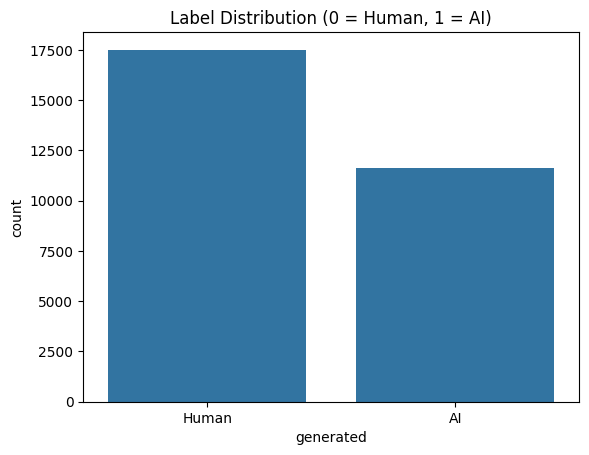

In [7]:
sns.countplot(x='generated', data=df)
plt.title("Label Distribution (0 = Human, 1 = AI)")
plt.xticks([0,1], ['Human', 'AI'])
plt.show()

Quick little visualization to once again see how the distrubtion of the texts is. nWe can see that there are a bit more human generated essays that AI generated ones.

### Analyze text lengths

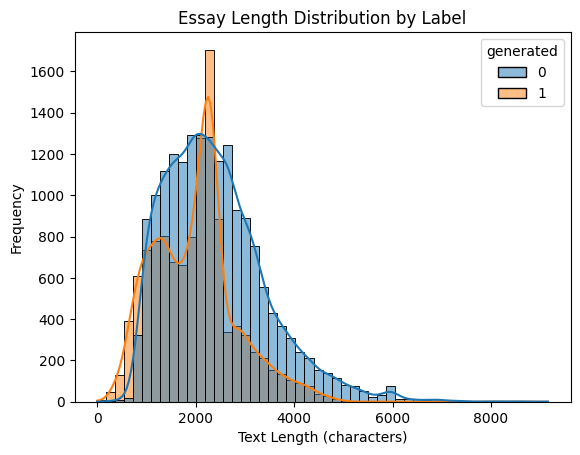


Average text length by label:
generated
0    2403.223669
1    1984.401908
Name: text_length, dtype: float64


In [8]:
df['text_length'] = df['text'].astype(str).apply(len)

sns.histplot(data=df, x='text_length', hue='generated', bins=50, kde=True)
plt.title("Essay Length Distribution by Label")
plt.xlabel("Text Length (characters)")
plt.ylabel("Frequency")
plt.show()

# Compare average lengths
print("\nAverage text length by label:")
print(df.groupby('generated')['text_length'].mean())

- From this visualization, we can see the AI generated text seems to have a higher frequency when it comes to a shorter or more concise essay (around 2000 characters).
- Additionally, there doesn't seem to be many larger length essays that are generated by AI. As we reach 4000 characters, it flattens out.
- On average, AI generated text is less in terms of amount of characters in comparison to human generated
- Overall, I would say that most of the text length for both types of text lie in between 1000-3000 characters

### Word Count

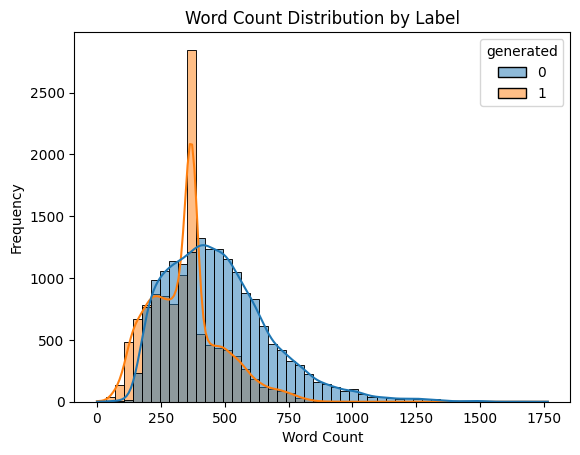

In [9]:
df['word_count'] = df['text'].apply(lambda x: len(word_tokenize(x)))

sns.histplot(data=df, x='word_count', hue='generated', bins=50, kde=True)
plt.title("Word Count Distribution by Label")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

### Get Readability Scores - Gets a score on how readable the text is (higher = better)

In [10]:
# readability - how easy it is to read the text
df['readability'] = df['text'].apply(textstat.flesch_reading_ease)

# gunning fog - how complex the text is (higher score = harder to read)
df['gunning_fog'] = df['text'].apply(textstat.gunning_fog)
# clip gunning_fog to a reasonable range
df['gunning_fog'] = df['gunning_fog'].clip(5, 20)

# smog index - also like gunning fog but mor strict and reliable for shorter texts
df['smog_index'] = df['text'].apply(textstat.smog_index)

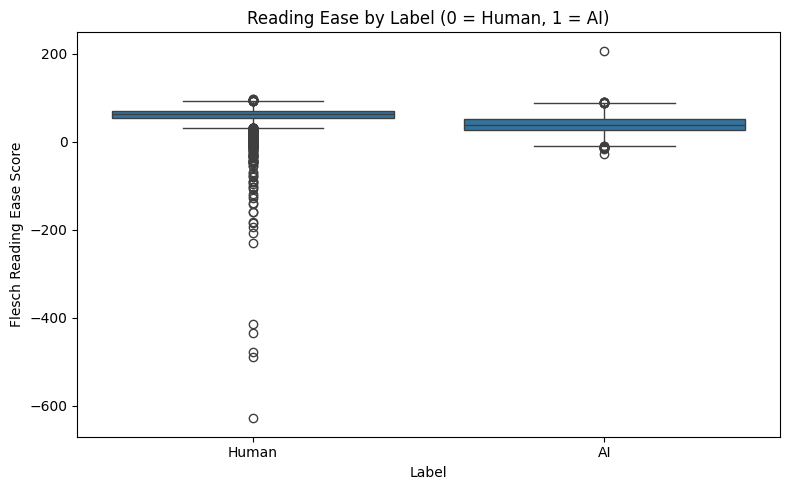

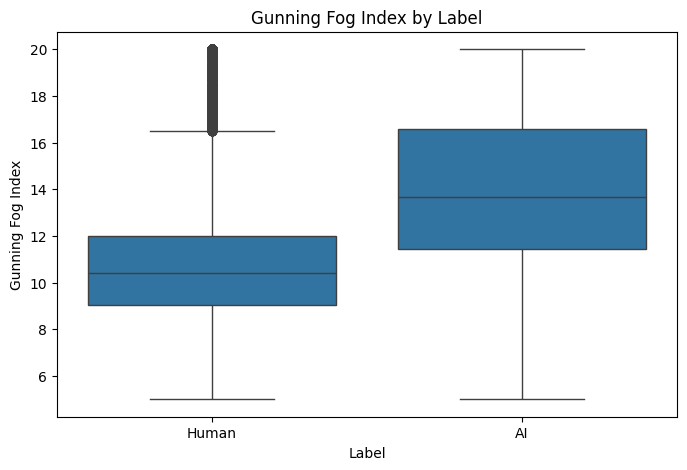

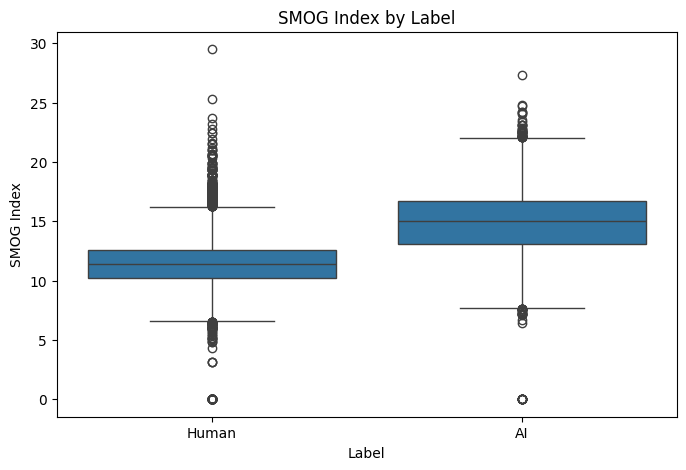

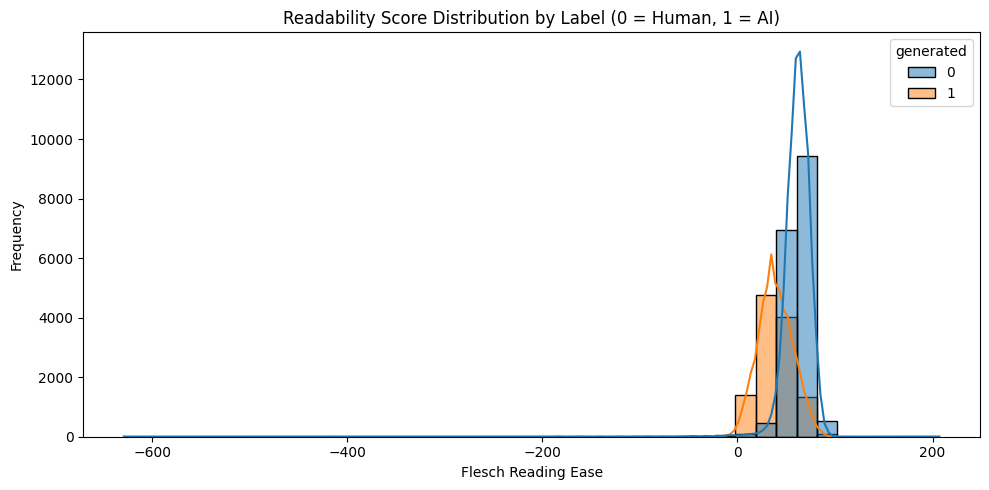

In [11]:
# readability scores
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='generated', y='readability')
plt.title("Reading Ease by Label (0 = Human, 1 = AI)")
plt.xlabel("Label")
plt.ylabel("Flesch Reading Ease Score")
plt.xticks([0, 1], ['Human', 'AI'])
plt.tight_layout()
plt.show()

# Gunning Fog
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='generated', y='gunning_fog')
plt.title("Gunning Fog Index by Label")
plt.xlabel("Label")
plt.ylabel("Gunning Fog Index")
plt.xticks([0,1], ['Human', 'AI'])
plt.show()

# SMOG Index
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='generated', y='smog_index')
plt.title("SMOG Index by Label")
plt.xlabel("Label")
plt.ylabel("SMOG Index")
plt.xticks([0,1], ['Human', 'AI'])
plt.show()

# readability score distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='readability', hue='generated', bins=40, kde=True)
plt.title("Readability Score Distribution by Label (0 = Human, 1 = AI)")
plt.xlabel("Flesch Reading Ease")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Takeaways from the visualizations:
- Humans have higher median scores in terms of readability. This suggests that human-written texts are easier to read
- AI texts have more variation, so there is a mix between it being too complex or too simple. Human texts are more centered and consistent.
- Human texts have a lot of outliers. This could be for reasons like poor grammar, sentence fragments, long/unstructured writing. AI has much fewer outliers which could suggest they are more polished structurally.
- AI-generated text seems to have higher SMOG/Gunning Fog scores. Therefore, we can assume that AI texts are more complex than human written text. This serves as a good factor to consider when trying to distinguish between both types of texts.
- AI-generated text might be too clean while human text contains more natural messiness.


### Getting Burstiness - Measures variability in sentence length or structure



In [12]:
def calc_burstiness(text):
    sentences = sent_tokenize(text)
    sent_lengths = [len(word_tokenize(s)) for s in sentences if len(word_tokenize(s)) > 0]
    if len(sent_lengths) < 2:
        return 0
    mean = np.mean(sent_lengths)
    std = np.std(sent_lengths)
    return std / mean  # coefficient of variation


df['burstiness'] = df['text'].apply(calc_burstiness)

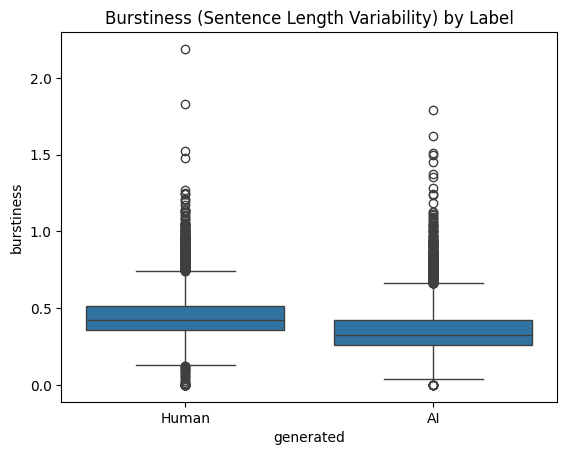

In [13]:
sns.boxplot(data=df, x='generated', y='burstiness')
plt.title("Burstiness (Sentence Length Variability) by Label")
plt.xticks([0, 1], ['Human', 'AI'])
plt.show()

Key Insights:
- Human texts show a bit more burstiness (higher burstiness = more variability in sentence length)
- AI texts are more consistent. They more better/more sentence structure
- Both have a lot of high-burstiness outliers, but humans have a wider spread which makes sense because we tend to have more natural or expressive writing.
- This supports the idea that humans vary sentence length more intuitively, while AI outputs are often more templated.


## Reviewing our EDA

In [14]:
# new features we have now
print(df.columns.tolist())

['text', 'generated', 'text_length', 'word_count', 'readability', 'gunning_fog', 'smog_index', 'burstiness']


In [16]:
print(df.sample(5)[['generated', 'text_length', 'word_count', 'readability', 'gunning_fog', 'smog_index', 'burstiness']])

       generated  text_length  word_count  readability  gunning_fog  \
28921          0         3322         635        47.83        12.62   
10422          0         1655         354        71.85         7.94   
515            1         4364         751        33.75        12.90   
19866          1          855         150        34.66        15.43   
20494          1         1431         266        38.35        15.48   

       smog_index  burstiness  
28921        14.4    0.484528  
10422         9.8    0.426974  
515          15.8    0.599194  
19866        14.3    0.328904  
20494        15.1    0.231256  


Overall:
- We have a couple of new features like text_length, readability, and burstiness which hopefully can help us determine how to classify text as AI generated or human generated later on.
- We can still implement new features, or we can go into trying to start our initial models and investigate which algorithims would be the best for this type of classification.